<a href="https://colab.research.google.com/github/maestros/nci_stock_prediction_cloud_ml/blob/main/Final_Solution_Next_Day_Multivariate_Time_Series_Models_WIP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1. Data load and preprocessing**

In [1]:
# Reference code to 
# https://github.com/flo7up/relataly-public-python-tutorials/blob/master/.ipynb_checkpoints/012%20Stock%20Market%20Prediction%20using%20Multivariate%20Time%20Series%20Models%20and%20Python-checkpoint.ipynb
%pip install prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
%pip install yfinance
import yfinance as yf # source for test data
from datetime import datetime, timedelta
import time 
import datetime as dt
###############################
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = (dt.datetime.now()- timedelta(days=3000)).strftime("%Y-%m-%d")

# Getting stock price quotes from YFinance
stockname = 'GOOG' # insert required stock symbol name here
symbol = 'GOOG' # insert required stock symbol name here

df = yf.download(symbol, start=date_start, end=date_today)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Create a quick overview of the dataset
train_dfs = df.copy()
train_dfs
df = train_dfs.dropna()
################ Data leak check #######

# # Select target
y = train_dfs.Close

# # Select predictors
X = train_dfs.drop(['Close'], axis=1)
y = y.reset_index(drop=True).copy()
y.head(5)

train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

##################### RandomForestRegressor check

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std

X_trainl, X_testl, y_trainl, y_testl = train_test_split(X, y, test_size=0.4, random_state=0)
model = RandomForestRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model,X_trainl, y_trainl, scoring='neg_mean_absolute_error', cv=cv,n_jobs=-1,error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

################### Linear regressor check

from sklearn import linear_model
from sklearn import model_selection

train_features, test_features, train_targets, test_targets = model_selection.train_test_split( X_trainl, y_trainl, test_size=0.2)
# Create an instance of a least-square regression algorithm and assess it's accuracy
# with default hyper-parameter settings
reg = linear_model.LinearRegression()
reg = reg.fit(train_features, train_targets)

from sklearn import metrics
#Predict the response for test dataset
y_pred = reg.predict(test_features)
print("Accuracy:", metrics.mean_squared_error(test_targets, y_pred))

from sklearn.model_selection import cross_val_score
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X_testl, y_testl,scoring='neg_mean_squared_error', cv=10)
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))


     |████████████████████████████████| 65 kB 1.4 MB/s 
     |████████████████████████████████| 49 kB 3.6 MB/s 
     |████████████████████████████████| 178 kB 11.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639173 sha256=60e402fb1b75dbdc8737e45175d75bffcb9e542847ccfebaf0439eb18dfe621f
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.

Step2. Create the training dataset and test data. Set up test RNN LSTM model.

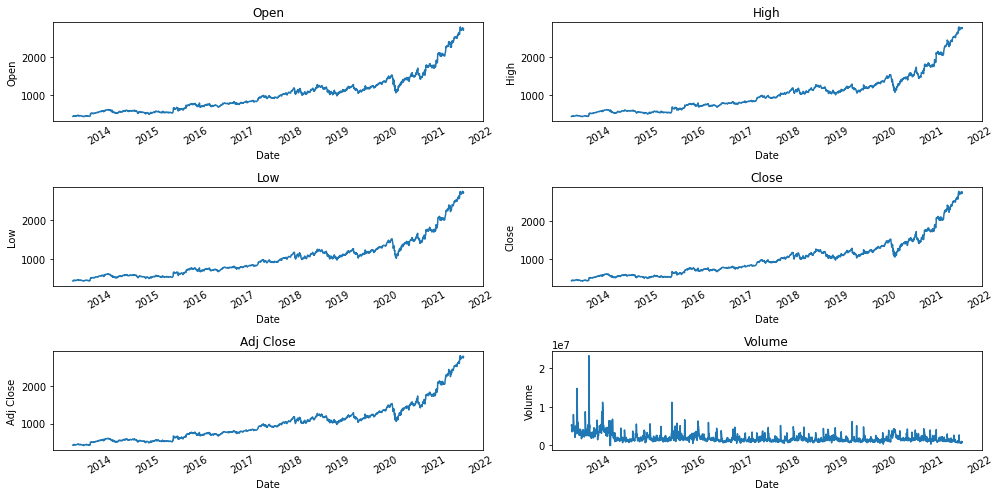

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2068, 5)
(1605, 50, 5) (1605,)
(413, 50, 5) (413,)
0.0014750194569294606
0.0014750194569294606
250 50 5


In [2]:

# Create the training and test data

# Plot histograms
df_plot = train_dfs.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

###################################

# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

################################

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
            ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()
###################################

# Get the number of rows in the data
#This  bit helps to resolve data leaks issues by using MinMaxscaler
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


###############################

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])
##########################################

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='Adamax', loss='mse')

Step 3. Training model

In [3]:

####################################################

# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

############################################



Epoch 1/50
101/101 [==============================] - 36s 320ms/step - loss: 6.4516e-04 - val_loss: 0.0013
Epoch 2/50
101/101 [==============================] - 31s 302ms/step - loss: 9.7317e-05 - val_loss: 9.9243e-04
Epoch 3/50
101/101 [==============================] - 29s 285ms/step - loss: 1.0375e-04 - val_loss: 8.0920e-04
Epoch 4/50
101/101 [==============================] - 29s 287ms/step - loss: 9.0475e-05 - val_loss: 7.1243e-04
Epoch 5/50
101/101 [==============================] - 29s 290ms/step - loss: 8.9893e-05 - val_loss: 5.9793e-04
Epoch 6/50
101/101 [==============================] - 29s 285ms/step - loss: 9.2907e-05 - val_loss: 5.3999e-04
Epoch 7/50
101/101 [==============================] - 30s 302ms/step - loss: 9.0251e-05 - val_loss: 8.0332e-04
Epoch 8/50
101/101 [==============================] - 30s 294ms/step - loss: 9.0782e-05 - val_loss: 0.0020
Epoch 9/50
101/101 [==============================] - 32s 314ms/step - loss: 9.5375e-05 - val_loss: 6.4858e-04
Epoch 10/

Step 4. Visualize training loss process results and display accuracy metrics

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


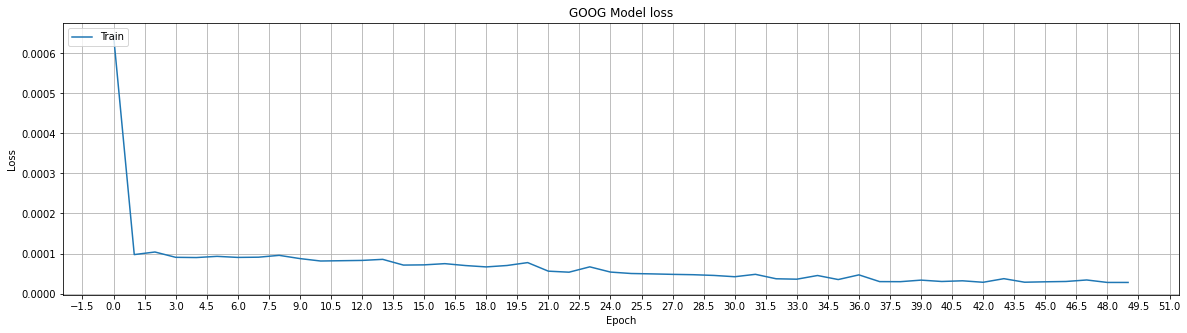

Median Absolute Error (MAE): 35.19
Mean Absolute Percentage Error (MAPE): 1.84 %
Median Absolute Percentage Error (MDAPE): 1.63 %
Root Square Mean Square Error (RSME): 46.36


In [4]:

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 5), sharex=True)

plt.plot(history.history["loss"])
plt.title(f'{stockname} Model loss', family='Arial', fontsize=12)
# plt.title(f'{company} Share Price"', family='Arial', fontsize=12)
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#################################################

# Get the predicted values
y_pred = model.predict(x_test)

# Unscale the predicted values
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

from sklearn.metrics import mean_squared_error
print('Root Square Mean Square Error (RSME): ' + str(np.round(mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False), 2)))


Step 5. Visualize predicted trained data vs actual CLose prices.

             High  Difference   Prediction  ...        Close   Volume       Date
2061  2768.360107  -81.129883  2686.660156  ...  2767.790039   732300 2021-08-12
2062  2773.479980  -82.907959  2685.212158  ...  2768.120117   628600 2021-08-13
2063  2779.810059  -77.356201  2700.963867  ...  2778.320068   902000 2021-08-16
2064  2774.370117  -59.063965  2686.946045  ...  2746.010010  1063600 2021-08-17
2065  2765.879883  -56.754883  2674.645020  ...  2731.399902   746700 2021-08-18
2066  2749.040039  -73.955078  2664.314941  ...  2738.270020   914800 2021-08-19
2067  2772.290039 -111.361328  2657.378662  ...  2768.739990   778200 2021-08-20

[7 rows x 8 columns]


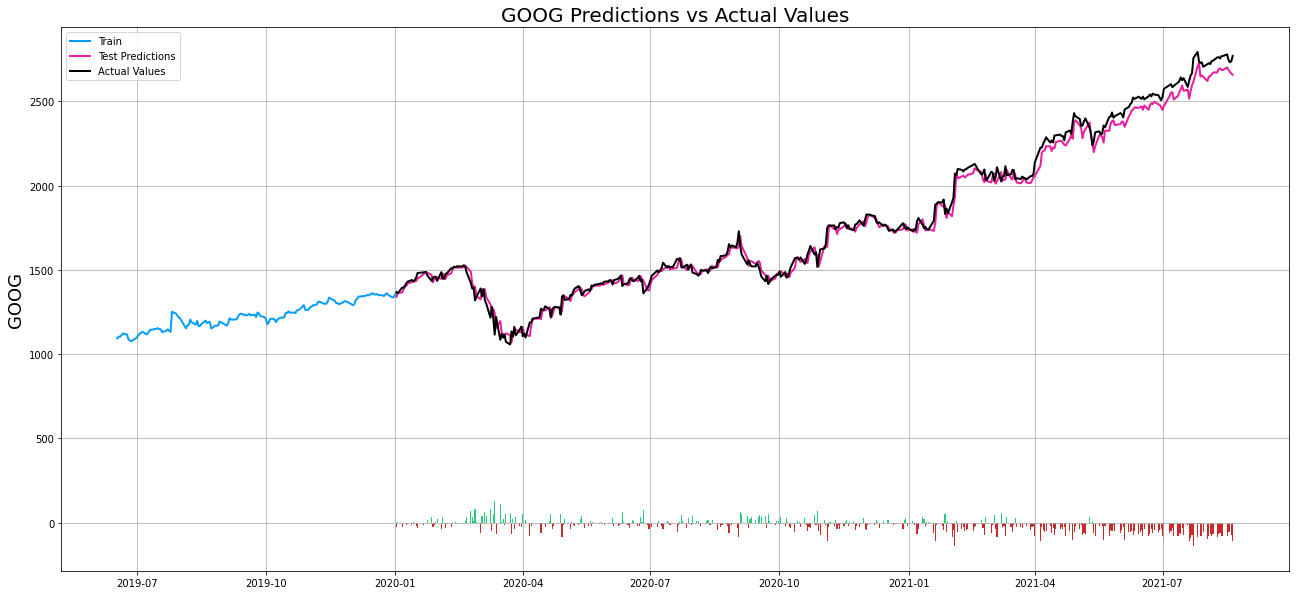

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Changepoint Detection
Trend and seasonality decomposition


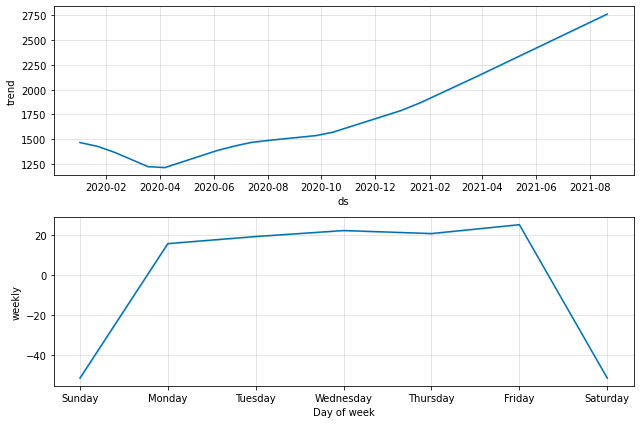

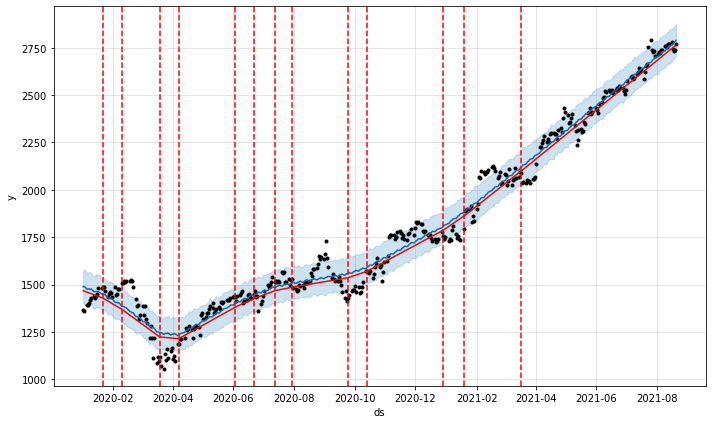

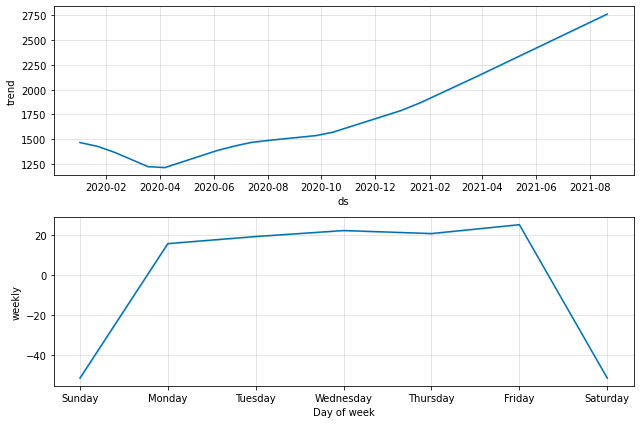

In [6]:
############################################################


# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=800)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]



valid.insert(1, "Prediction", y_pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

print(valid.tail(7))

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title(f'{stockname} Predictions vs Actual Values', fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

###############################################
prediction_train_df_reset = valid
prediction_train_df_reset.rename(columns = {'Date':'ds', 'Close':'y'}, inplace=True)
m = Prophet()
m.fit(prediction_train_df_reset)
forecast = m.predict(prediction_train_df_reset)
fig = m.plot(forecast)

# Changepoint detection diagram
print("Changepoint Detection")
add_changepoints_to_plot(fig.gca(), m, forecast)

# Trend and seasonality decomposition diagrams
print("Trend and seasonality decomposition")
m.plot_components(forecast)


Step 6. Predict next day price and compare with actual stock Close price

In [7]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
new_df.tail(3)

The close price for GOOG at 2021-08-23 was 2768.74
The predicted close price is 2702.639892578125 (-2.45%)


,High,Low,Open,Close,Volume
Date,,,,,
2021-08-18,2765.879883,2728.419922,2742.310059,2731.399902,746700
2021-08-19,2749.040039,2707.120117,2709.350098,2738.270020,914800
2021-08-20,2772.290039,2729.340088,2741.659912,2768.739990,778200
